In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import numpy as np
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
import pickle

from tqdm import tqdm
import os
import tensorflow as tf

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, CuDNNLSTM
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [0]:
import sqlite3

con = sqlite3.connect('/content/drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

('Number of data points in our data', (525814, 10))


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Remove duplicates

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)


(364173, 10)


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(364171, 10)


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:58<00:00, 2037.87it/s]


In [0]:
from sklearn.model_selection import train_test_split

final['CleanedText']=preprocessed_reviews

x_train, x_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

print(x_train.shape)
print(x_test.shape)


(254919,)
(109252,)


In [0]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)

In [0]:
tokenizer.fit_on_texts(x_train)

In [0]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)

In [0]:
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [0]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)
print(np.mean(num_tokens))
print(np.max(num_tokens))

37.66651929999917
1406


In [0]:
#Assuming gaussian distribution for length of reviews
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
print(max_tokens)

109


In [0]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [0]:
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding='pre', truncating='pre')

In [0]:
x_train_pad.shape

(254919, 109)

In [0]:
x_test_pad.shape

(109252, 109)

In [0]:
# map indexes to words
index = tokenizer.word_index
inverse_map = dict(zip(index.values(), index.keys()))

In [0]:
#function to return string given sequence of integer tokens
def word_sequence(tokens):
  word_sequence = [inverse_map[token] for token in tokens if token!=0]
  return ' '.join(word_sequence)

In [0]:
#example
word_sequence(x_train_tokens[0])

u'little book makes son laugh loud car driving along always sing learned india roses love new words book classic book willing bet son still able memory college'

**Using CuDNNLSTM : Fast LSTM implementation with CuDNN.**

In [0]:
embedding_vecor_length = 100
model = Sequential()
model.add(Embedding(max_words, embedding_vecor_length, input_length=max_tokens))
model.add(tf.keras.layers.CuDNNLSTM(100)) #Fast implementation of LSTM
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 109, 100)          1000000   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,080,901
Trainable params: 1,080,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [0]:
%%time
history = model.fit(x_train_pad, y_train,
          validation_data=(x_test_pad,y_test), epochs=3, batch_size=100)

Train on 254919 samples, validate on 109252 samples
Epoch 1/3
254919/254919 [==============================] - 71s 279us/step - loss: 0.1998 - acc: 0.9221 - val_loss: 0.1794 - val_acc: 0.9284
Epoch 2/3
254919/254919 [==============================] - 70s 276us/step - loss: 0.1462 - acc: 0.9442 - val_loss: 0.1512 - val_acc: 0.9405
Epoch 3/3
254919/254919 [==============================] - 70s 276us/step - loss: 0.1207 - acc: 0.9547 - val_loss: 0.1534 - val_acc: 0.9411
CPU times: user 2min 41s, sys: 48.9 s, total: 3min 30s
Wall time: 3min 32s


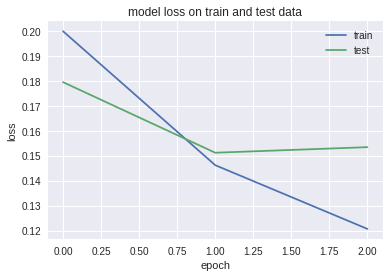

********************************************************************************************************************************************************************************************************
('Test accuracy', 0.941099478460583)


In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss on train and test data')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

print('*'*200)
print('Test accuracy',history.history['val_acc'][-1])

**Using 300 dimensions for embedding vector to see if performance improves**

In [0]:
embedding_vecor_length = 300
model = Sequential()
model.add(Embedding(max_words, embedding_vecor_length, input_length=max_tokens))
model.add(tf.keras.layers.CuDNNLSTM(100)) #Fast implementation of LSTM
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 109, 300)          3000000   
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 100)               160800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 3,160,901
Trainable params: 3,160,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [0]:
%%time
history = model.fit(x_train_pad, y_train,
          validation_data=(x_test_pad,y_test), epochs=3, batch_size=100)

Train on 254919 samples, validate on 109252 samples
Epoch 1/3
254919/254919 [==============================] - 88s 346us/step - loss: 0.1923 - acc: 0.9255 - val_loss: 0.1566 - val_acc: 0.9384
Epoch 2/3
254919/254919 [==============================] - 86s 339us/step - loss: 0.1349 - acc: 0.9489 - val_loss: 0.1519 - val_acc: 0.9406
Epoch 3/3
254919/254919 [==============================] - 87s 340us/step - loss: 0.1079 - acc: 0.9595 - val_loss: 0.1537 - val_acc: 0.9415
CPU times: user 3min 5s, sys: 1min 3s, total: 4min 9s
Wall time: 4min 21s


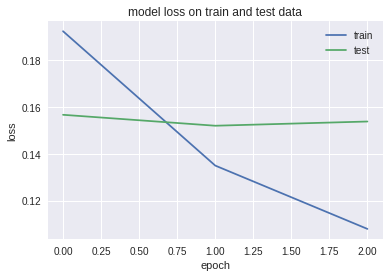

********************************************************************************************************************************************************************************************************
('Test accuracy', 0.9415113708229471)


In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss on train and test data')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

print('*'*200)
print('Test accuracy',history.history['val_acc'][-1])

In [0]:
from prettytable import PrettyTable
tab = PrettyTable()
tab.field_names = ["Embedding vector length","Epochs","Test Accuracy"]
list1=["100","3","0.9410"]
list2=["300","3","0.9415"]
tab.add_row(list1)
tab.add_row(list2)

print(tab) 

+-------------------------+--------+---------------+
| Embedding vector length | Epochs | Test Accuracy |
+-------------------------+--------+---------------+
|           100           |   3    |     0.9410    |
|           300           |   3    |     0.9415    |
+-------------------------+--------+---------------+
